In [1]:
import torch
from datasets import load_dataset
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model


/home/sachchida/anaconda3/envs/cuda13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import torch
import os

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def print_model_size(model, name="model"):
    torch.save(model.state_dict(), f"{name}.pt")
    size_mb = os.path.getsize(f"{name}.pt") / (1024 ** 2)
    print(f"{name} size on disk: {size_mb:.2f} MB")
    os.remove(f"{name}.pt")

def human_readable(num):
    for unit in ["", "K", "M", "B"]:
        if num < 1000:
            return f"{num:.2f}{unit}"
        num /= 1000


In [5]:
from datasets import load_dataset


dataset = load_dataset("ashraq/financial-news", split="train")
print(dataset)


Repo card metadata block was not found. Setting CardData to empty.
Generating train split: 100%|██████████| 1845559/1845559 [00:00<00:00, 7107089.24 examples/s]

Dataset({
    features: ['headline', 'url', 'publisher', 'date', 'stock'],
    num_rows: 1845559
})


In [7]:
# convert small slice for visualization
df = dataset.to_pandas().sample(5000, random_state=42)
df.head()

,headline,url,publisher,date,stock
948540,KMG Chemicals' (KMG) CEO Chris Fraser on Q1 20...,http://seekingalpha.com/article/3748906-kmg-ch...,Seeking Alpha,2015-12-10 00:00:00,KMG
769643,"90 Champions, Contenders And Challengers Are D...",https://seekingalpha.com/article/4219769-90-ch...,Seeking Alpha,2018-11-08 00:00:00,HEP
195804,"Pabrai Funds Portfolio Review: POT, BPO, BIP, ...",http://www.gurufocus.com/news/148936/pabrai-fu...,GuruFocus,2011-10-21 00:00:00,BIP
3553,"Auto Stock Roundup: Toyota Stays Top Seller, F...",http://www.zacks.com/stock/news/161391/auto-st...,Zacks,2015-01-22 00:00:00,AAP
1716112,Deutsche Bank raises VMware price target to 17...,https://seekingalpha.com/news/3326141-deutsche...,Seeking Alpha,2018-01-29 00:00:00,VMW


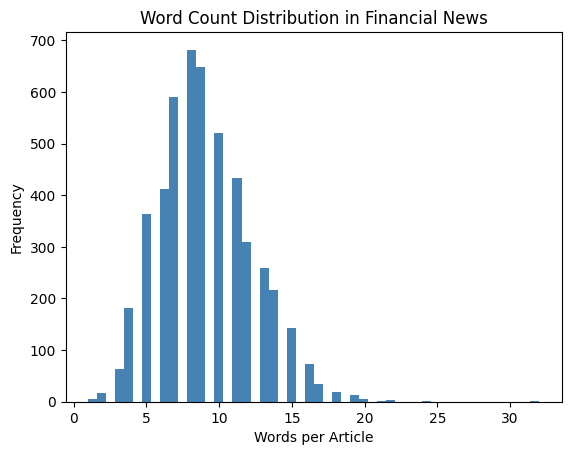

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# convert small slice for visualization
df = dataset.to_pandas().sample(5000, random_state=42)

# distribution of word counts
df["length"] = df["headline"].str.split().apply(len)

plt.hist(df["length"], bins=50, color="steelblue")
plt.title("Word Count Distribution in Financial News")
plt.xlabel("Words per Article")
plt.ylabel("Frequency")
plt.show()


In [9]:
dataset = dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]


In [10]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_name = "gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)


`torch_dtype` is deprecated! Use `dtype` instead!


### Inspect GPT-2 (Before LoRA)

In [13]:
total, trainable = count_parameters(model)

print("🔹 BASE GPT-2")
print(f"Total parameters     : {human_readable(total)}")
print(f"Trainable parameters : {human_readable(trainable)}")
print(f"Trainable %          : {100 * trainable / total:.2f}%")

print_model_size(model, "gpt2_base")


🔹 BASE GPT-2
Total parameters     : 124.44M
Trainable parameters : 124.44M
Trainable %          : 100.00%
gpt2_base size on disk: 237.40 MB


In [14]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 811,008 || all params: 125,250,816 || trainable%: 0.6475


/home/sachchida/anaconda3/envs/cuda13/lib/python3.13/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [11]:
def tokenize(examples):
    return tokenizer(
        examples["headline"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_tok = train_dataset.map(tokenize, batched=True)
eval_tok = eval_dataset.map(tokenize, batched=True)

train_tok = train_tok.remove_columns(["url", "headline","publisher","date","stock"])
eval_tok = eval_tok.remove_columns(["url", "headline","publisher","date","stock"])

train_tok.set_format("torch")
eval_tok.set_format("torch")


Map: 100%|██████████| 184556/184556 [00:11<00:00, 15657.82 examples/s]


In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

training_args = TrainingArguments(
    output_dir="../model/gpt2_finance_lora",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    eval_steps=500,
    logging_steps=200,
    num_train_epochs=3,
    fp16=True,
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=eval_tok,
    data_collator=data_collator,
)


The model is already on multiple devices. Skipping the move to device specified in `args`.


In [16]:
trainer.train()


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
200,5.200100
400,4.818300
600,4.735300
800,4.676500
1000,4.604900
1200,4.531700
1400,4.528300
1600,4.481000
1800,4.422900
2000,4.397300


KeyboardInterrupt: 

In [18]:
total, trainable = count_parameters(model)

print("🔹 GPT-2 + LoRA")
print(f"Total parameters     : {human_readable(total)}")
print(f"Trainable parameters : {human_readable(trainable)}")
print(f"Trainable %          : {100 * trainable / total:.4f}%")

print_model_size(model, "gpt2_lora")

🔹 GPT-2 + LoRA
Total parameters     : 125.25M
Trainable parameters : 811.01K
Trainable %          : 0.6475%
gpt2_lora size on disk: 240.56 MB


In [ ]:
model.save_pretrained("../model/gpt2_finance_lora")
tokenizer.save_pretrained("../model/gpt2_finance_lora")
